### Initial Setup

In [1]:
# Install
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Import
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile 
from skimage import io 
from torch.utils.data import Dataset
import torch 
import pandas as pd 
from torchvision import transforms
import copy
from sklearn.metrics import mean_squared_error

In [3]:
# System Check
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [4]:
# Find GPU
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
# Reserve GPU
if IN_CADE:
    define_gpu_to_use()

Chosen GPU: 0


### Load and Visualize Dataset

In [6]:
# Opens zip file and places data in datsets folder
def open_zip(filename):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

In [7]:
# Return indexes to split data by for train, val, and test
# Splits are 70% train, 10% val, 20% test
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [8]:
# Dataset class for Truss (Bracket/Beam) dataset
class TrussDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        # Get the split
        all_attributes_frame = pd.read_csv(root_dir + csv_file)
        ids = get_split(pd.unique(all_attributes_frame['ID']), split)
        self.attributes_frame = all_attributes_frame[all_attributes_frame['ID'].isin(ids)]
              
    def __len__(self):
        return len(self.attributes_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.attributes_frame.iloc[idx, 1])
        image = io.imread(image_name)
        image = image.astype(np.float32)
        image = image[:,:,:3]
        image = image/255
        image = np.swapaxes(image, 0, 1)
        image = np.swapaxes(image, 0, 2)
        attributes = self.attributes_frame.iloc[idx, 2:].values
        attributes = attributes.astype('float')
        attribute_names = self.attributes_frame.columns[2:].values
        return torch.FloatTensor(image), torch.FloatTensor(attributes), list(attribute_names)

In [9]:
# Open zip of dataset
open_zip('trussData.zip')

In [10]:
# Create train, val, and test datasets
train_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/')
val_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='val')
test_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='test')

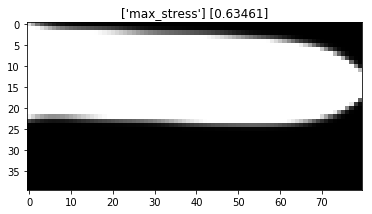

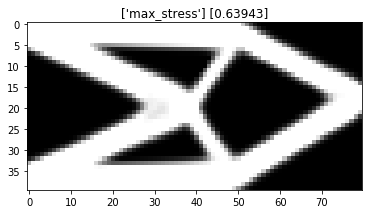

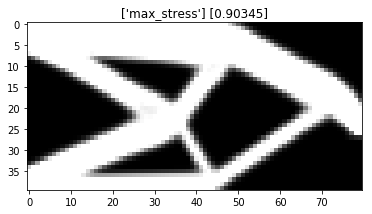

In [11]:
# Visualing a few cases of the training set
for batch_idx, (image, attribute, name) in enumerate(train_dataset):
    if batch_idx%250 == 0: 
        plt.figure()
        plt.title(str(name) + ' ' + str(attribute.cpu().numpy()))
        plt.imshow(image[:,:,:].permute([1, 2, 0]).cpu().numpy())

In [12]:
# Calculates L2 for images and MSE for regression - want both close to 0
def get_score_model(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        distances = []
        mse = []
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, logvar, reg = model(image)
            # Reconstruction Score
            euclidean_dist = torch.pow(torch.sum(torch.pow((image - recon), 2)), 0.5)
            distances.append(euclidean_dist.cpu().numpy())
            # Regression Score
            y_true = attribute.cpu().numpy()
            y_pred = reg.cpu().numpy()         
            mse.append(mean_squared_error(y_true, y_pred))
    
    return np.mean(distances), np.mean(mse)

In [13]:
# Classes to create VAE, ability to change kernel_size of filters for convolution layers
# and the latent representation dim
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.batch = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

class TransBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransBlock, self).__init__()
        self.convT = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.convT(x)
        return x

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 32, 5, 10) # see if there is a way to not have this hardcoded

In [14]:
# VAE with Regression - The reconstruction and regression are done from the
# latent variables calculated from the reparametrization (distribution)
class VAE_REG(torch.nn.Module):
    def __init__(self, kernel_size, z_dim):
        super(VAE_REG, self).__init__()
        self.encoder = torch.nn.Sequential(
        ConvBlock(in_channels=3, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=8, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=16, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        Flatten()) 
        
        self.mu = torch.nn.Linear(1600, z_dim)
        self.logvar = torch.nn.Linear(1600, z_dim)
        self.fc = torch.nn.Linear(z_dim, 1600)
        
        self.decoder = torch.nn.Sequential(
        UnFlatten(),
        TransBlock(in_channels=32, out_channels=32),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=16, kernel_size=kernel_size),
        TransBlock(in_channels=16, out_channels=16),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=8, kernel_size=kernel_size),
        TransBlock(in_channels=8, out_channels=8),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=3, kernel_size=kernel_size))
        
        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=z_dim, out_features=4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=1))
            
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.FloatTensor(mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, x):
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def forward(self, x):
        x = self.encoder(x)
        z, mu, logvar = self.bottleneck(x) # z is latent representation
        x = self.fc(z)
        x = torch.sigmoid(self.decoder(x)) # VAE output
        r = self.regression(z) # Regression output
        return x, mu, logvar, r

In [15]:
# Loss function for this task, combines reconstruction and KL for the image task and the MSELoss
# for the regression task
def loss_function(reconstruction, image, mu, logvar, attributes, r, batch_size):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstruction, image)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /=  batch_size * image.shape[1] * image.shape[2] * image.shape[3]
    reg_loss =  torch.nn.MSELoss()
    return reconstruction_loss, kl_loss, reg_loss(attributes, r)

In [16]:
# VAE conv kernel size = 7 z_dim=2
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_score = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = VAE_REG(kernel_size=7, z_dim=2)
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

train_recon_scores = []
train_r2_scores = []
val_recon_scores = []
val_r2_scores = []
target_score = 35.5 # Want score to be less than this
best_score = 50
best_model = copy.deepcopy(model)

print('Starting Training!')
for epoch in range(n_epochs):
    print('\nEpoch: ' + str(epoch))
    scheduler.step()
    
    model.train()
    
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    reg_losses = []
    for image, attribute, name in train_loader:
        optimizer.zero_grad()
        image = image.cuda()
        attribute = attribute.cuda()
        recon, mu, logvar, reg = model(image)
        reconstruction_loss, kl_loss, reg_loss = loss_function(recon, image, mu, logvar, attribute, reg, BATCH_SIZE)
        loss = reconstruction_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()
        
        total_losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())
        reg_losses.append(reg_loss.item())
        
    print('Total Loss: ' + str(np.mean(total_losses)))
    print('Reconstruction Loss: ' + str(np.mean(reconstruction_losses)))
    print('KL Loss: ' + str(np.mean(kl_losses)))
    print('Regression Loss: ' + str(np.mean(reg_losses)))
    
    # Get training data accuracy
    train_recon_score, train_r2 = get_score_model(model, train_loader_score)
    print('Trainig Reconstruction Score: ' + str(train_recon_score))
    print('Training MSE Score: ' + str(train_r2))
    train_recon_scores.append(train_recon_score)
    train_r2_scores.append(train_r2)
    
    # Get validation data accuracy
    val_recon_score, val_r2 = get_score_model(model, val_loader)
    print('Validation Reconstruction Score: ' + str(val_recon_score))
    print('Validation MSE Score: ' + str(val_r2))
    val_recon_scores.append(val_recon_score)
    val_r2_scores.append(val_r2)
    
    # Save Best Model - Based on Reconstruction Score
    if val_recon_score < target_score and val_recon_score < best_score:
        best_score = val_recon_score
        best_model = copy.deepcopy(model)
        print('New Best Model Saved!')

Starting Training!

Epoch: 0
Total Loss: 0.7365141212940216
Reconstruction Loss: 0.6579576339040484
KL Loss: 0.015216188103503165
Regression Loss: 0.06334029827765854
Trainig Reconstruction Score: 42.794823
Training MSE Score: 0.005469131
Validation Reconstruction Score: 42.99991
Validation MSE Score: 0.0049476316

Epoch: 1
Total Loss: 0.6251249304839543
Reconstruction Loss: 0.6119291475840978
KL Loss: 0.006736446504614183
Regression Loss: 0.0064593374662633455
Trainig Reconstruction Score: 40.71143
Training MSE Score: 0.006753414
Validation Reconstruction Score: 40.94625
Validation MSE Score: 0.007180597

Epoch: 2
Total Loss: 0.5903626927307674
Reconstruction Loss: 0.5781197454248156
KL Loss: 0.0037876681125323685
Regression Loss: 0.008455278045896972
Trainig Reconstruction Score: 40.28756
Training MSE Score: 0.009378132
Validation Reconstruction Score: 40.272858
Validation MSE Score: 0.010580914

Epoch: 3
Total Loss: 0.5616701790264674
Reconstruction Loss: 0.5512253871985844
KL Loss:

Trainig Reconstruction Score: 35.496326
Training MSE Score: 0.004848995
Validation Reconstruction Score: 35.74538
Validation MSE Score: 0.00424975

Epoch: 28
Total Loss: 0.4687440995659147
Reconstruction Loss: 0.46249579531805857
KL Loss: 0.0014574588775368674
Regression Loss: 0.004790845917471286
Trainig Reconstruction Score: 35.383682
Training MSE Score: 0.004598858
Validation Reconstruction Score: 35.606297
Validation MSE Score: 0.0040007727

Epoch: 29
Total Loss: 0.4706001196588789
Reconstruction Loss: 0.4642584409032549
KL Loss: 0.0015277684799262455
Regression Loss: 0.004813910713918241
Trainig Reconstruction Score: 35.451706
Training MSE Score: 0.0048948964
Validation Reconstruction Score: 35.72455
Validation MSE Score: 0.0036583291

Epoch: 30
Total Loss: 0.46688604014260426
Reconstruction Loss: 0.46069498104708534
KL Loss: 0.001473345557626869
Regression Loss: 0.004717713492989008
Trainig Reconstruction Score: 35.652164
Training MSE Score: 0.0045614797
Validation Reconstruction

Trainig Reconstruction Score: 34.63103
Training MSE Score: 0.0045559052
Validation Reconstruction Score: 35.01039
Validation MSE Score: 0.0036871347
New Best Model Saved!

Epoch: 55
Total Loss: 0.44871722417218346
Reconstruction Loss: 0.4425997406244278
KL Loss: 0.0014251290238462388
Regression Loss: 0.004692354577127844
Trainig Reconstruction Score: 34.836212
Training MSE Score: 0.0046225255
Validation Reconstruction Score: 35.18397
Validation MSE Score: 0.003634871

Epoch: 56
Total Loss: 0.4470135152339935
Reconstruction Loss: 0.440830129810742
KL Loss: 0.0014335194477877978
Regression Loss: 0.004749866575002671
Trainig Reconstruction Score: 34.686672
Training MSE Score: 0.0047309087
Validation Reconstruction Score: 35.06681
Validation MSE Score: 0.0037108874

Epoch: 57
Total Loss: 0.44630604130881174
Reconstruction Loss: 0.44023519371237074
KL Loss: 0.0014348146505653858
Regression Loss: 0.004636033646862155
Trainig Reconstruction Score: 35.200783
Training MSE Score: 0.006977028
Val

Trainig Reconstruction Score: 34.358543
Training MSE Score: 0.004571389
Validation Reconstruction Score: 34.939945
Validation MSE Score: 0.003636593

Epoch: 82
Total Loss: 0.43571132293769294
Reconstruction Loss: 0.42957758477755953
KL Loss: 0.0013922244834247977
Regression Loss: 0.004741510452835687
Trainig Reconstruction Score: 34.269928
Training MSE Score: 0.004506562
Validation Reconstruction Score: 34.91472
Validation MSE Score: 0.0034805313

Epoch: 83
Total Loss: 0.435103166103363
Reconstruction Loss: 0.42897421760218485
KL Loss: 0.0013842427920150969
Regression Loss: 0.0047447064342642465
Trainig Reconstruction Score: 34.207058
Training MSE Score: 0.005328373
Validation Reconstruction Score: 34.75918
Validation MSE Score: 0.004449339

Epoch: 84
Total Loss: 0.4404786429234913
Reconstruction Loss: 0.4343957896743502
KL Loss: 0.0013973513435173248
Regression Loss: 0.004685500999247389
Trainig Reconstruction Score: 34.405174
Training MSE Score: 0.0046232603
Validation Reconstruction

Validation Reconstruction Score: 34.7727
Validation MSE Score: 0.003489711

Epoch: 109
Total Loss: 0.4303799991096769
Reconstruction Loss: 0.4243748694658279
KL Loss: 0.0013832238818784909
Regression Loss: 0.004621904884697869
Trainig Reconstruction Score: 34.08459
Training MSE Score: 0.004505347
Validation Reconstruction Score: 34.659035
Validation MSE Score: 0.0034137904

Epoch: 110
Total Loss: 0.43112985364028383
Reconstruction Loss: 0.42506391065461296
KL Loss: 0.001380153836882008
Regression Loss: 0.004685789594493274
Trainig Reconstruction Score: 34.12301
Training MSE Score: 0.004592918
Validation Reconstruction Score: 34.84267
Validation MSE Score: 0.003663824

Epoch: 111
Total Loss: 0.42874940165451597
Reconstruction Loss: 0.42270354287964956
KL Loss: 0.0013456824360348815
Regression Loss: 0.004700178368615785
Trainig Reconstruction Score: 33.9427
Training MSE Score: 0.0044950955
Validation Reconstruction Score: 34.67549
Validation MSE Score: 0.003459133

Epoch: 112
Total Loss:

Total Loss: 0.427458718419075
Reconstruction Loss: 0.4215542239802224
KL Loss: 0.0013405474235436746
Regression Loss: 0.004563948700004923
Trainig Reconstruction Score: 33.883163
Training MSE Score: 0.004638491
Validation Reconstruction Score: 34.66094
Validation MSE Score: 0.0036079842

Epoch: 137
Total Loss: 0.42683743025575366
Reconstruction Loss: 0.42079907187393734
KL Loss: 0.0013377823367980975
Regression Loss: 0.004700576519826427
Trainig Reconstruction Score: 33.79619
Training MSE Score: 0.004550836
Validation Reconstruction Score: 34.588425
Validation MSE Score: 0.0034087845

Epoch: 138
Total Loss: 0.42724315864699225
Reconstruction Loss: 0.42127984634467536
KL Loss: 0.0013290634262375534
Regression Loss: 0.004634248553442636
Trainig Reconstruction Score: 34.159466
Training MSE Score: 0.004817789
Validation Reconstruction Score: 34.846413
Validation MSE Score: 0.003999891

Epoch: 139
Total Loss: 0.4262788734265736
Reconstruction Loss: 0.4203202698911939
KL Loss: 0.001344094993

Total Loss: 0.41912812888622286
Reconstruction Loss: 0.4133400346551623
KL Loss: 0.001315202595599528
Regression Loss: 0.004472890393143253
Trainig Reconstruction Score: 33.543026
Training MSE Score: 0.004434232
Validation Reconstruction Score: 34.443787
Validation MSE Score: 0.0034378374

Epoch: 164
Total Loss: 0.4189970885004316
Reconstruction Loss: 0.41321863787514823
KL Loss: 0.0013156736094970256
Regression Loss: 0.0044627792235197765
Trainig Reconstruction Score: 33.54377
Training MSE Score: 0.0044418527
Validation Reconstruction Score: 34.431034
Validation MSE Score: 0.003367219

Epoch: 165
Total Loss: 0.418811571598053
Reconstruction Loss: 0.41301420203277045
KL Loss: 0.0013120198697184346
Regression Loss: 0.004485349693901039
Trainig Reconstruction Score: 33.55245
Training MSE Score: 0.004441542
Validation Reconstruction Score: 34.418766
Validation MSE Score: 0.003375669
New Best Model Saved!

Epoch: 166
Total Loss: 0.41900463785443987
Reconstruction Loss: 0.41324296849114556


Total Loss: 0.418380845444543
Reconstruction Loss: 0.41260195842811037
KL Loss: 0.0013054000030803894
Regression Loss: 0.004473486930198435
Trainig Reconstruction Score: 33.51719
Training MSE Score: 0.0044385046
Validation Reconstruction Score: 34.42848
Validation MSE Score: 0.003383581

Epoch: 191
Total Loss: 0.4182601170880454
Reconstruction Loss: 0.41249074552740367
KL Loss: 0.0013073075762284653
Regression Loss: 0.004462062003689685
Trainig Reconstruction Score: 33.528767
Training MSE Score: 0.004434736
Validation Reconstruction Score: 34.433216
Validation MSE Score: 0.0033591925

Epoch: 192
Total Loss: 0.41815084772450584
Reconstruction Loss: 0.4123991961990084
KL Loss: 0.0013059212851138518
Regression Loss: 0.004445730553873415
Trainig Reconstruction Score: 33.514717
Training MSE Score: 0.0044502816
Validation Reconstruction Score: 34.432297
Validation MSE Score: 0.003355647

Epoch: 193
Total Loss: 0.41827726108687263
Reconstruction Loss: 0.41250222495623995
KL Loss: 0.0013057393

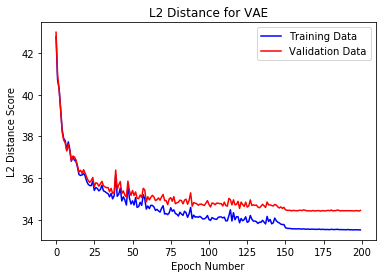

In [17]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_recon_scores, 'b', range(n_epochs), val_recon_scores, 'r')
plt.title('L2 Distance for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('L2 Distance Score')
plt.show()

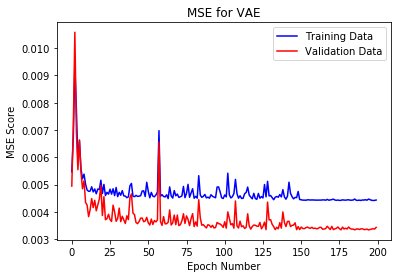

In [18]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_r2_scores, 'b', range(n_epochs), val_r2_scores, 'r')
plt.title('MSE for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('MSE Score')
plt.show()

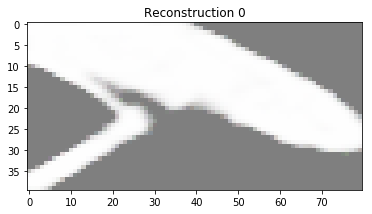

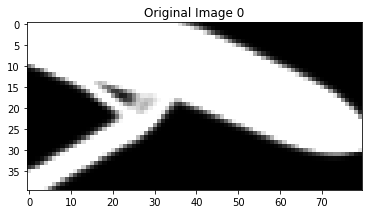

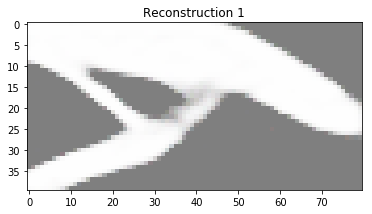

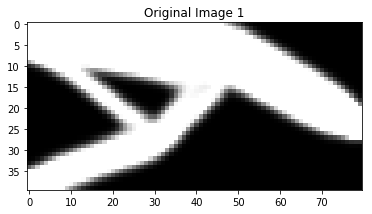

In [20]:
# Show examples of the ground truth image and the reconstruction after
# a pass through the autoencoder
def get_example_outputs(model, data_loader):
    model.eval()
    ground_truth = []
    model_output = []
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, var, r = model(image)
            model_output.append(recon)
            ground_truth.append(image)
            if len(model_output) == 2:
                return model_output, ground_truth
            
model_out, gt = get_example_outputs(model, val_loader)
for idx in range(2):
    plt.figure()
    plt.title("Reconstruction " + str(idx))
    model_out[idx] = model_out[idx].view(model_out[idx].shape[1], model_out[idx].shape[2], model_out[idx].shape[3])
    plt.imshow(model_out[idx].permute([1, 2, 0]).cpu().numpy())
    plt.figure()
    plt.title("Original Image " + str(idx))
    gt[idx] = gt[idx].view(gt[idx].shape[1], gt[idx].shape[2], gt[idx].shape[3])
    plt.imshow(gt[idx].permute([1, 2, 0]).cpu().numpy())

In [21]:
test_recon_score, test_mse_score = get_score_model(best_model, test_loader)
print('Test L2 Score: ' + str(test_recon_score))
print('Test MSE Score: ' + str(test_mse_score))

Test L2 Score: 34.203804
Test MSE Score: 0.0049356245
